# Management Sentiment Analysis 

_Life is a math equation. In order to gain the most, you have to know how to convert negatives into positives_ - Anonymous

Concepts:
- Sentiment Analysis
- SEC Edgar

References:
- Tim Loughran and Bill McDonald, 2011, When is a Liability not a Liability? Textual Analysis, Dictionaries, and 10-Ks, Journal of Finance, 66:1, 35-65. 
- Cohen, Malloy and Nguyen (2020), Lazy Prices, Journal of Finance, Volume 75, Issue3, June 2020, Pages 1371-1415


In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm
from finds.database import SQL, RedisDB
from finds.structured import BusDay, CRSP, Signals
from finds.unstructured import Edgar
from finds.readers import Alfred
from finds.recipes import weighted_average, fractile_split
from finds.utils import Store
from secret import credentials, paths, CRSP_DATE
# %matplotlib qt
VERBOSE = 0
LAST_YEAR = CRSP_DATE // 10000

In [2]:
sql = SQL(**credentials['sql'], verbose=VERBOSE)
user = SQL(**credentials['user'], verbose=VERBOSE)
bd = BusDay(sql)
rdb = RedisDB(**credentials['redis'])
crsp = CRSP(sql=sql, bd=bd, rdb=rdb, verbose=VERBOSE)
ed = Edgar(paths['10X'], zipped=True, verbose=VERBOSE)
signals = Signals(user)
store = Store(paths['scratch'], ext='pkl')

Last FamaFrench Date 2024-04-30 00:00:00


## Sentiment analysis

Dictionary-based (also known as lexicon-based) sentiment analysis uses lists of words which have been pre-scored for sentiment as well as the strength of the sentiment. However, this approach struggles in interpreting negations, irony, and sarcasm which can reduce accuracy. In contrast, large language models are better at understanding context, syntax, and semantics, leading to more accurate sentiment analysis, especially for complex sentences. Nevertheless, dictionary-based sentiment analysis is quick, easy to implement, and results are straightforward to interpret.

### Loughran and MacDonald dictionary

Loughran and McDonald (2011) noted that general sentiment lexicons were not good fits for analyzing the sentiment of financial statements.  Drawing from company 10-K filings, they scored individual words across different seven categories of sentiments important in financial contexts: "negative", "positive", "litigious", "uncertainty", "constraining", or "superfluous"

- https://sraf.nd.edu/loughranmcdonald-master-dictionary/


In [3]:
# to download from google drive, need this prefix and the file id
_prefix = "https://drive.google.com/uc?export=download&id=" 
source =  _prefix + '1ptUgGVeeUGhCbaKL14Ri3Xi5xOKkPkUD'
# source = "Loughran-McDonald_MasterDictionary_1993-2023.csv"
df = pd.read_csv(source, sep=',')

# sets of positive and negative sentiment words
words = {'positive': set(df.loc[df['Positive'] != 0, 'Word'].str.lower()),
         'negative': set(df.loc[df['Negative'] != 0, 'Word'].str.lower())}

Positive sentiment words

In [4]:
DataFrame(words['positive'], columns=['Positive Words'])

,Positive Words
0,leadership
1,meritorious
2,distinctions
3,improving
4,versatile
...,...
349,distinction
350,beautifully
351,gained
352,attain


Negative sentiment words

In [5]:

DataFrame(words['negative'], columns=['Negative Words'])

,Negative Words
0,disaster
1,disparagement
2,misapplies
3,weaknesses
4,oppose
...,...
2350,nondisclosure
2351,unprofitability
2352,defended
2353,confront


List of stop words to ignore

In [6]:
# stopwords
generic = ['ME', 'MY', 'MYSELF', 'WE', 'OUR', 'OURS', 'OURSELVES',
           'YOU', 'YOUR', 'YOURS', 'YOURSELF', 'YOURSELVES',
           'HE', 'HIM', 'HIS', 'HIMSELF', 'SHE', 'HER', 'HERS',
           'HERSELF', 'IT', 'ITS', 'ITSELF', 'THEY', 'THEM',
           'THEIR', 'THEIRS', 'THEMSELVES', 'WHAT', 'WHICH',
           'WHO', 'WHOM', 'THIS', 'THAT', 'THESE', 'THOSE',
           'AM', 'IS', 'ARE', 'WAS', 'WERE', 'BE', 'BEEN',
           'BEING', 'HAVE', 'HAS', 'HAD', 'HAVING', 'DO',
           'DOES', 'DID', 'DOING', 'AN', 'THE', 'AND', 'BUT',
           'IF', 'OR', 'BECAUSE', 'AS', 'UNTIL', 'WHILE', 'OF',
           'AT', 'BY', 'FOR', 'WITH', 'ABOUT', 'BETWEEN',
           'INTO', 'THROUGH', 'DURING', 'BEFORE', 'AFTER',
           'ABOVE', 'BELOW', 'TO', 'FROM', 'UP', 'DOWN', 'IN',
           'OUT', 'ON', 'OFF', 'OVER', 'UNDER', 'AGAIN',
           'FURTHER', 'THEN', 'ONCE', 'HERE', 'THERE', 'WHEN',
           'WHERE', 'WHY', 'HOW', 'ALL', 'ANY', 'BOTH', 'EACH',
           'FEW', 'MORE', 'MOST', 'OTHER', 'SOME', 'SUCH',
           'NO', 'NOR', 'NOT', 'ONLY', 'OWN', 'SAME', 'SO',
           'THAN', 'TOO', 'VERY', 'CAN', 'JUST', 'SHOULD',
           'NOW', 'AMONG']

In [7]:
# CountVectorizer to tokenize and code counts of inputs words
vectorizer = CountVectorizer(strip_accents='unicode',
                             lowercase=True,
                             stop_words=generic,
                             token_pattern=r"\b[^\d\W][^\d\W][^\d\W]+\b")

In [8]:
# vectorizer to encode sentiment dictionary words 
sentiment_vectorizer = CountVectorizer(strip_accents='unicode',
                                       lowercase=True,
                                       token_pattern=r"\b[^\d\W][^\d\W][^\d\W]+\b")
sentiment_vectorizer.fit([" ".join(words['positive'].union(words['negative']))])

# create a lookup Series and a score vector for computing net sentiment
features = Series(sentiment_vectorizer.get_feature_names_out())
sentiment_points = (features.isin(words['positive']).astype(int).values 
                    - features.isin(words['negative']).astype(int).values)

## SEC Edgar company filings

The SEC EDGAR (Electronic Data Gathering, Analysis, and Retrieval) system is an online database operated by the U.S. Securities and Exchange Commission (SEC). It provides public access to financial filings and disclosure documents submitted by publicly traded companies, such as annual and quarterly reports (Forms 10-K and 10-Q), significant events (Form 8-K), beneficial ownership reports (Schedule 13D), insider sales (Form 144), proxy statements, and registration statements (S-1).

- https://www.sec.gov/edgar/search-and-access

### 10-Ks

A 10-K is a comprehensive annual report filed by publicly traded companies with the SEC. It provides a detailed overview of the company's financial performance and operations, including dedicated sections for business description, management discussion and analysis (MD&A) and risk factors, as well as financial statements.


In [9]:
# open 10-K archive of MD&A text
item, form = 'mda10K', '10-K'
rows = DataFrame(ed.open(form=form, item=item))
Series((rows['date'] // 10000).astype(int)).value_counts().sort_index().to_frame()

,count
date,
1993,2
1994,1362
1995,1674
1996,2960
1997,4461
1998,4501
1999,4364
2000,4287
2001,4168


Compute the average sentiment, and change in sentiment, of 10-K's for all investment universe stocks between 1993 through the present.

In [10]:
# retrieve usual universe at end of each year
univs = {year: crsp.get_universe(bd.endyr(year-1)).assign(year=year)
         for year in range(1992, LAST_YEAR + 1)}
permnos = rows['permno'].unique().astype(int)
DataFrame({'permnos': len(permnos),
           'documents': len(rows),
           'first': min(rows['date']),
           'last': max(rows['date'])},
          index=['10K-mdas'])

,permnos,documents,first,last
10K-mdas,14499,133190,19931129,20231229


In [30]:
# Compute average sentiment and change in sentiment for all companies and years
results = []
for permno in tqdm(permnos):  # Loop over all permnos
    
    # retrieve all valid mda's for this permno by year
    mdas, dates = {}, {}   # to collect mdas and doc dates for this permno
    docs = rows[rows['permno'].eq(permno)].to_dict('records')
    for doc in docs:
        year = bd.endmo(doc['date'], -3) // 10000   # assign fiscal year
        if (year in univs and (year not in mdas or doc['date'] < dates[year])):
            tokens = ed[doc['pathname']]
            if len(tokens):
                mdas[year] = tokens
                dates[year] = doc['date']

    # compute sentiment as net sentiment word counts divided by doc length
    if len(mdas):
        X = sentiment_vectorizer.transform(list(mdas.values()))\
                                .dot(sentiment_points)
        X = np.divide(X, vectorizer.fit_transform(list(mdas.values())).sum())
        sentiment = {k:x for k,x in zip(mdas.keys(), X)}
    
    # derive sentiment change and similarity scores by year
    for year in sorted(mdas.keys()):
        result = {'year': year, 'permno': permno, 'date': dates[year]}
        result['mdasent'] = sentiment[year]
        result['currlen'] = len(mdas[year])
        if year-1 in mdas:
            result['prevlen'] = len(mdas[year-1])
            result['mdachg'] = sentiment[year] - sentiment[year-1]

            corpus = [mdas[year], mdas[year-1]]
        results.append(result)

  0%|          | 0/14499 [00:00<?, ?it/s]/home/terence/env3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['about', 'above', 'after', 'again', 'all', 'among', 'and', 'any', 'are', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'can', 'did', 'does', 'doing', 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'has', 'have', 'having', 'her', 'here', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'into', 'its', 'itself', 'just', 'more', 'most', 'myself', 'nor', 'not', 'now', 'off', 'once', 'only', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 'same', 'she', 'should', 'some', 'such', 'than', 'that', 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 'through', 'too', 'under', 'until', 'very', 'was', 'were', 'what', 'when', 'where', 'which', 'whil

In [31]:
# save in signals database
data = DataFrame.from_records(results)
data['rebaldate'] = bd.offset(data['date'])
print(signals.write(data, 'mdasent', overwrite=True),
      signals.write(data, 'mdachg', overwrite=True))

(signals_write) mdasent 126842
(signals_write) mdachg 103966
126842 103966


In [32]:
# right join data with univ, to identify universe companies with missing mda
data = pd.concat([data[data['year']==year]\
                  .drop(columns=['year'])\
                  .set_index('permno')\
                  .join(univ[['year']], how='right')\
                  .reset_index()
                  for year, univ in univs.items() if year < LAST_YEAR],
                 ignore_index=True)
# store temporary
store['sentiment'] = data

In [11]:
data = store['sentiment']

Show universe coverage by year

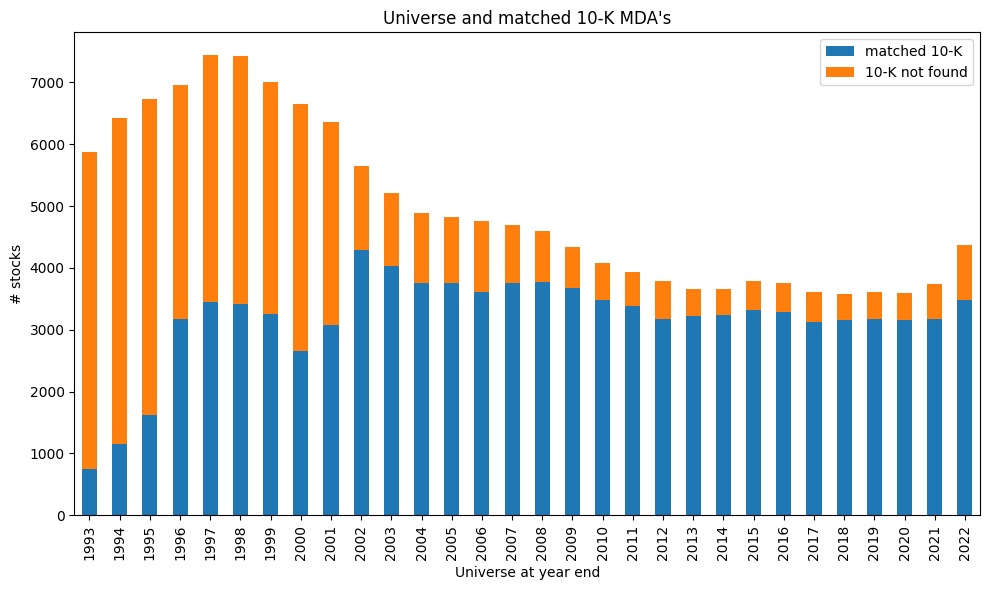

In [12]:
# Stacked Bar Plot of universe coverage by year
y1 = data[data['mdasent'].notna()].groupby('year')['permno'].count()
y0 = data[data['mdasent'].isna()].groupby('year')['permno']\
                                 .count()\
                                 .reindex(y1.index)
fig, ax = plt.subplots(1, 1, clear=True, figsize=(10, 6))
y1.plot(kind='bar', label='matched 10-K', color='C0', ax=ax, rot=90)
y0.plot(kind='bar', label='10-K not found', color='C1', ax=ax, rot=90, bottom=y1)
ax.set_ylabel('# stocks')
ax.set_xlabel('Universe at year end')
ax.set_title("Universe and matched 10-K MDA's")
ax.legend()
plt.tight_layout()

When are 10-K's filed?

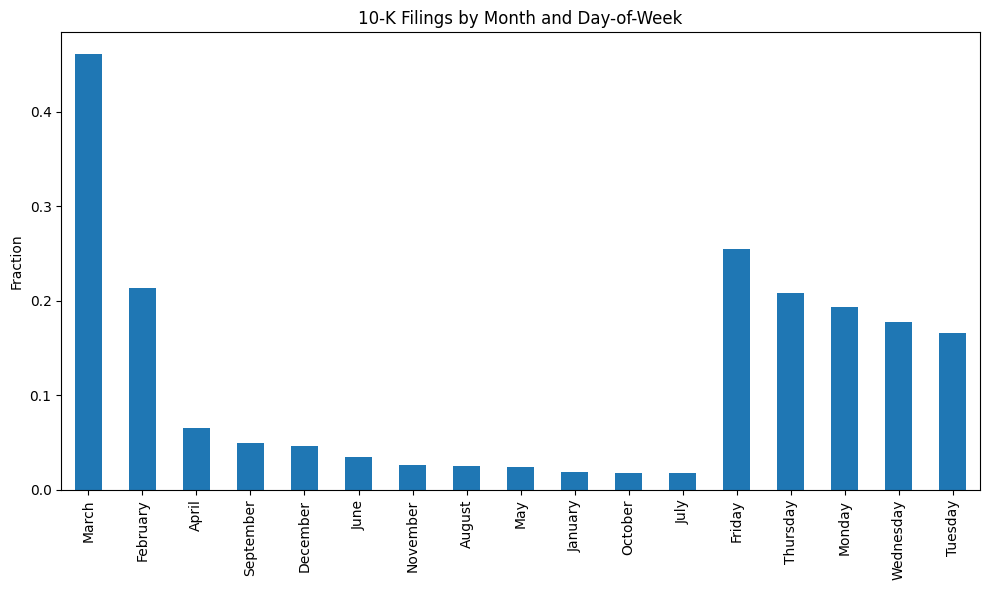

In [13]:
# Stacked Bar Plot of filings date, by month and day-of-week
y = DataFrame.from_records([{'date': int(d),
                             'day': bd.datetime(int(d)).strftime('%A'),
                             'month': bd.datetime(int(d)).strftime('%B')}
                            for d in data.loc[data['mdasent'].notna(), 'date']])
z = pd.concat([y['month'].value_counts()/len(y),
               y['day'].value_counts()/len(y)])
fig, ax = plt.subplots(1, 1, clear=True, figsize=(10, 6))
z.plot(kind='bar', color='C0', ax=ax, rot=90)
ax.set_ylabel('Fraction')
ax.set_title("10-K Filings by Month and Day-of-Week")
plt.tight_layout()

Show the median sentiment and change in sentiment vs total corporate profits (of all US companies), by year 

mdasent sentiment
mdachg sentiment change


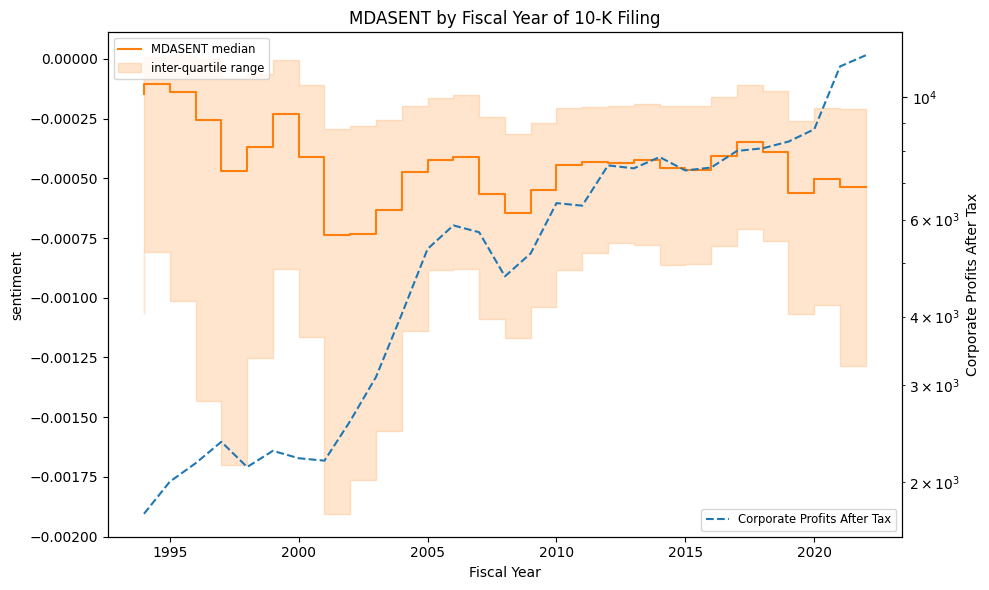

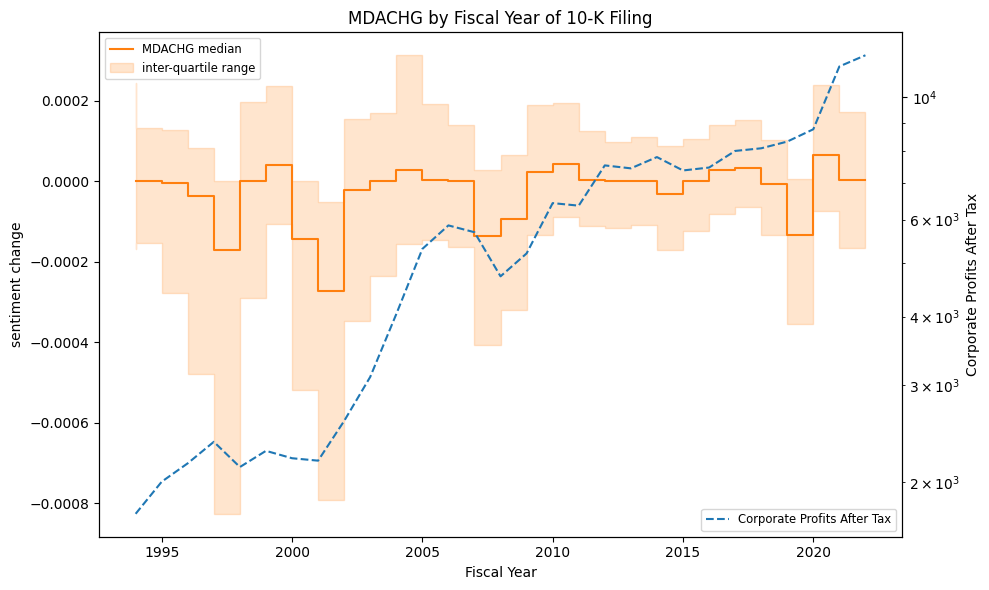

In [14]:
alf = Alfred(api_key=credentials['fred']['api_key'], verbose=VERBOSE)
series_id = 'CP'  # Corporate Profits
econ = alf(series_id).to_frame()
econ = econ.assign(year=econ.index // 10000).groupby('year').sum()
           
for sent, ylab in {'mdasent': 'sentiment', 'mdachg': 'sentiment change'}.items():
    print(sent, ylab)
    g = data[data['currlen'].gt(500)].dropna().groupby('year')
    iq1, iq2, iq3 = [g[sent].quantile(p) for p in [.25, .5, .75]]
    y = iq2.index.astype(int)
    fig, ax = plt.subplots(1, 1, clear=True, figsize=(10, 6))
    ax.step(y, iq2, ls='-', color='C1', where='pre')
    ax.fill_between(y, iq1, iq3, alpha=0.2, color='C1', step='pre')
    ax.set_title(f"{sent.upper()} by Fiscal Year of 10-K Filing")
    ax.set_xlabel("Fiscal Year")
    ax.set_ylabel(ylab)
    ax.legend([f"{sent.upper()} median", f"inter-quartile range"],
              fontsize='small', loc='upper left')

    bx = ax.twinx()
    econ[(econ.index >= min(y)) & (econ.index <= max(y))].plot(ls='--', ax=bx)
    bx.legend([alf.header(series_id)[:27]], fontsize='small', loc='lower right')
    bx.set_ylabel(alf.header(series_id)[:27])
    bx.set_yscale('log')
    plt.tight_layout()

Compute decile cap-weighted spread returns, both in same year (Jan-Dec) and year ahead (Apr-Mar). The former case shows the contemporaneous relationship between stock returns and the sentiment of 10-K report for the same calendar year, whereas the latter is an investable strategy after 10-K's (for the prior fiscal year) are released.


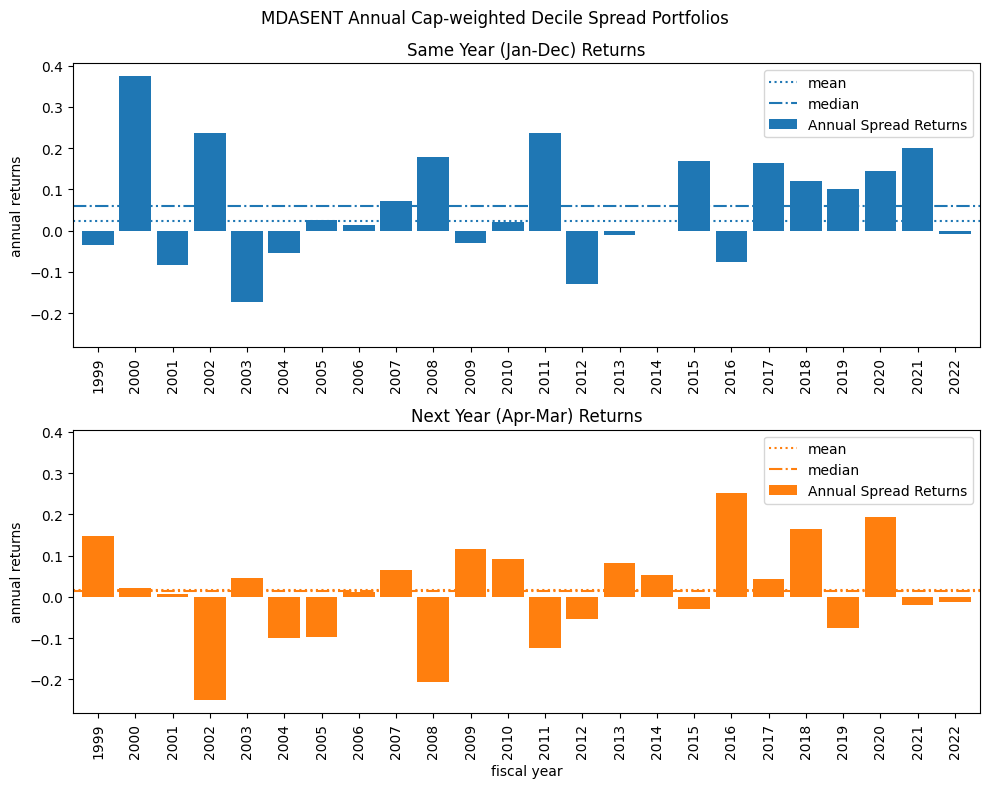

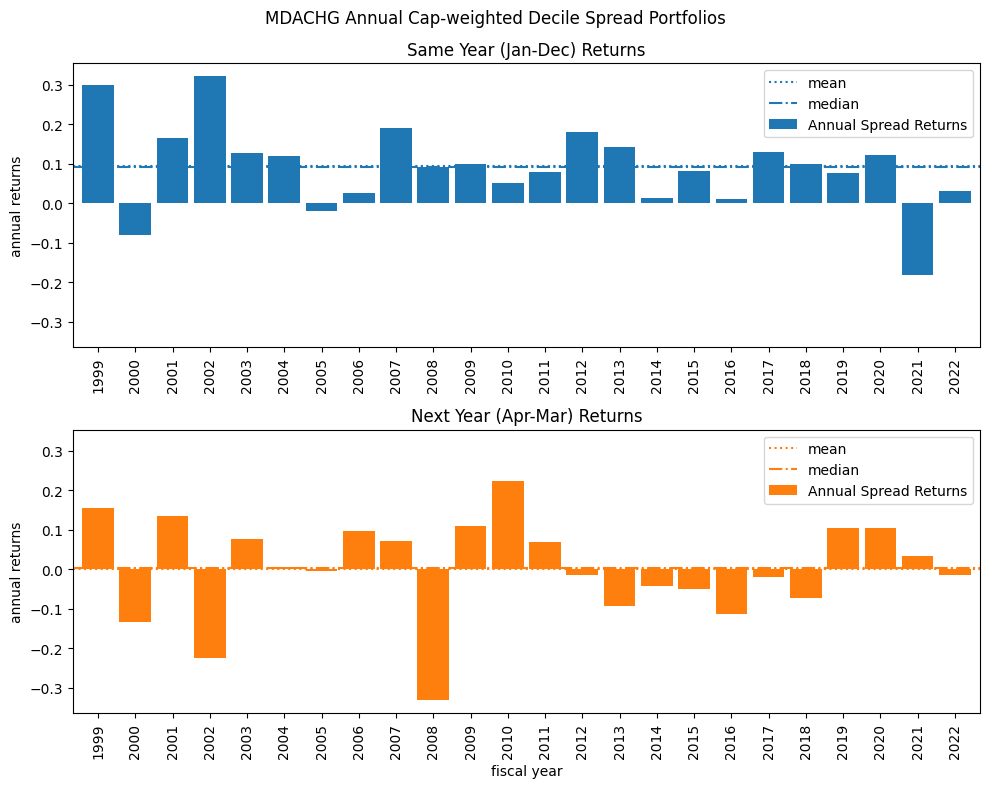

In [18]:
for ifig, key in enumerate(['mdasent', 'mdachg']):
    ret1 = {}   # to collect year-ahead spread returns
    ret0 = {}   # to collect current-year spread returns
    for year in range(1999, max(data['year'])+1):  # loop over years
        
        # compute current year average spread returns
        begyr = bd.begyr(year)
        endyr = bd.endyr(year)
        univ = data[data['year'] == year]\
                   .dropna(subset=[key])\
                   .set_index('permno')\
                   .join(crsp.get_cap(bd.offset(begyr, -1)), how='inner')\
                   .join(crsp.get_ret(begyr, endyr), how='left')
        if len(univ):
            sub = fractile_split(univ[key], [10, 90])
            pos = weighted_average(univ.loc[sub==1, ['cap', 'ret']], 'cap')['ret']
            neg = weighted_average(univ.loc[sub==3, ['cap', 'ret']], 'cap')['ret']
            ret0[endyr] = {'ret': pos-neg, 'npos': sum(sub==1), 'nneg': sum(sub==3)}

        # compute year ahead average spread returns
        beg = bd.begmo(endyr, 4)
        end = bd.endmo(endyr, 15)
        univ = data[data['year'] == year]\
                   .dropna(subset=[key])\
                   .set_index('permno')\
                   .join(crsp.get_cap(bd.offset(beg, -1)), how='inner')\
                   .join(crsp.get_ret(beg, end), how='left')
        if len(univ):
            sub = fractile_split(univ[key], [10, 90])
            pos = weighted_average(univ.loc[sub==1, ['cap', 'ret']], 'cap')['ret']
            neg = weighted_average(univ.loc[sub==3, ['cap', 'ret']], 'cap')['ret']
            ret1[end] = {'ret': pos-neg, 'npos': sum(sub==1), 'nneg': sum(sub==3)}

    # collect same-year and year-ahead average spread returns
    r0 = DataFrame.from_dict(ret0, orient='index').sort_index()
    r0.index = r0.index // 10000
    r1 = DataFrame.from_dict(ret1, orient='index').sort_index()
    r1.index = (r1.index // 10000) - 2

    # plot same-year average spread returns
    fig, ax = plt.subplots(nrows=2, clear=True, figsize=(10, 8), sharey=True)
    r0['ret'].plot(kind='bar', ax=ax[0], width=.85, color="C0")
    ax[0].axhline(r0['ret'].median(), linestyle=':', color='C0')
    ax[0].axhline(r0['ret'].mean(), linestyle='-.', color='C0')
    ax[0].set_title(f"Same Year (Jan-Dec) Returns")
    ax[0].set_ylabel('annual returns')
    ax[0].legend(['mean', 'median', 'Annual Spread Returns'])
    
    # plot year-ahead average spread returns
    r1['ret'].plot(kind='bar', ax=ax[1], width=.85, color="C1")
    ax[1].axhline(r1['ret'].median(), linestyle=':', color='C1')
    ax[1].axhline(r1['ret'].mean(), linestyle='-.', color='C1')
    ax[1].set_title(f"Next Year (Apr-Mar) Returns")
    ax[1].set_ylabel('annual returns')
    ax[1].legend(['mean', 'median', 'Annual Spread Returns'])
    ax[1].set_xlabel('fiscal year')
    
    plt.suptitle(f"{key.upper()} Annual Cap-weighted Decile Spread Portfolios")    
    plt.tight_layout()